In [1]:
#single_image = r"C:\Users\danie\Desktop\tiny rainbow.jpg"
image_folder = r"C:\Users\midyr\Downloads\colorwheels"
image_pathway = r"C:\Users\midyr\Downloads\colorwheels\MicrosoftTeams-image.png"

TOO_SMALL = 20
SMALL = 500000
MEDIUM = 1200000
LARGE = 2100000
    
X_train = []
Y_train = []
counter = 1
    
height = 128
width = 128

epochs = 10 
batch_size = 1 
total_images = 1

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage
import glob
import cv2
import pandas as pd

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, UpSampling2D, InputLayer, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage import data, io, color
from skimage.io import imread, imshow, imsave
from pathlib import Path

from sklearn.decomposition import PCA

import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
def shape(img):
    size = 0
    resolution = img.shape[0] * img.shape[1]
    if resolution <= TOO_SMALL:
        size = 0
    elif resolution <= SMALL:
        size = 1
    elif resolution <= MEDIUM:
        size = 2
    elif resolution <= LARGE:
        size = 3
    else:
        size = 6
    return size

In [4]:
def create_dataframe(image_folder):
    images = Path(image_folder).glob('*.png') #.jpg

    list_of_files = []
    for image in images:
        list_of_files.append(str(image))

    df = pd. DataFrame(list_of_files, columns = ["image_path"])
    df_length = len(df.index)
    
    print("processing", df_length, "photos for training")
    
    height_list= []
    width_list = []
    resolution = []
    
    for image_path in df['image_path']:
        img = cv2.imread(str(image_path))
        height_list.append(img.shape[0])
        width_list.append(img.shape[1])
        
    df["height"] = height_list
    df["width"] = width_list
    df["resolution"] = df["height"] * df["width"]
    
    df = df[df.resolution < LARGE]
    
    ll = df_length - len(df.index)
    print("dropped ", ll, "photos because they were too large to process")
    
    df = df[df.resolution > TOO_SMALL]
    
    ss = df_length - len(df.index) - ll
    print("dropped ", ss, "photos because they were too small to process")
    df.head()
    
    return df

In [5]:
def pca_rgb(imgBGR, size): #imgRGB, size
    b,g,r = cv2.split(imgBGR)
    list_channels = [b,g,r]
    
    #check size first
    if size ==1:
        inverted_img = []
        for c in list_channels:            
            pca = PCA(n_components = 100)
            transformed = pca.fit_transform(c/255) #r_scaled
            inverted = pca.inverse_transform(transformed)
            inverted_img.append(inverted)
        
        tuple(inverted_img)
        RGB_compressed = cv2.merge(inverted_img)    

    elif size == 2:
        inverted_img = []
        for c in list_channels:            
            pca = PCA(n_components = 300)
            transformed = pca.fit_transform(c/255) #r_scaled
            inverted = pca.inverse_transform(transformed)
            inverted_img.append(inverted)
        
        tuple(inverted_img)
        RGB_compressed = cv2.merge(inverted_img)
    else:
        inverted_img = []
        for c in list_channels:            
            pca = PCA(n_components = 500)
            transformed = pca.fit_transform(c/255) #r_scaled
            inverted = pca.inverse_transform(transformed)
            inverted_img.append(inverted)
        
        tuple(inverted_img)
        RGB_compressed = cv2.merge(inverted_img)
        
    RGB_compressed = np.float32(RGB_compressed)
    print("PCA SHAPE",np.min(RGB_compressed),np.max(RGB_compressed))    
    return RGB_compressed

In [6]:
def rgb_pad(image):
    
    img_height = image.shape[0]
    print(height)
    img_width = image.shape[1]
    print(width)
    
    WHITE = [255,255,255] #[255,255,255]  1, 1, 1
    
    if img_height % 2 == 0:
        top = int((height - img_height)/ 2)
        bottom = int((height - img_height)/ 2)
    else: 
        top = int((height - (img_height-1))/ 2)
        bottom = int(((height - (img_height-1))/ 2)-1)

    if img_width % 2 == 0:
        left = int((width - img_width)/ 2)
        right = int((width - img_width)/ 2)
    else: 
        left = int((width - (img_width-1))/ 2)
        right = int(((width - (img_width-1))/2)-1)
    
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT,value=WHITE)
    print(image.shape)
    print(np.min(image),np.max(image))

    return image

In [7]:
def prep_img(img_path):
    imgRGB = img_to_array(load_img(img_path))
    imgRGB = np.array(imgRGB, dtype=float)
    print('Padded:', np.min(imgRGB), np.max(imgRGB))



    image_size_category = shape(imgRGB) 
    if image_size_category <1:
        raise Exception("Your image is too small to be used")
    elif image_size_category >4:
        raise Exception("Your image is too big to be used")

    if PCA_YN == "yes":
        RGB_compressed = pca_rgb(imgRGB, image_size_category)
        RGB_compressed = np.clip(RGB_compressed,0,1) * 255
        print("PCA ran")
    else:
        RGB_compressed = imgRGB
        print("PCA did not run")


    
    padded_image = rgb_pad(RGB_compressed)

    print('Padded:', np.min(padded_image), np.max(padded_image))
    X_LAB = color.rgb2lab(1.0/255*padded_image)[:,:,0] #1.0/255*padded_image
    print('X_LAB:', np.min(X_LAB), np.max(X_LAB))
    Y_LAB1 = color.rgb2lab(1.0/255*padded_image)[:,:,1:] #1.0/255*padded_image
    print('Y_LAB1:', np.min(Y_LAB1), np.max(Y_LAB1))
    Y_LAB = Y_LAB1 / 128
    print('Y_LAB:', np.min(Y_LAB), np.max(Y_LAB))


    print(X_LAB.shape)
    X = X_LAB.reshape(1, height, width, 1) #comment out when show predicted
    Y = Y_LAB.reshape(1, height, width, 2) #comment out when show predicted
    
    print("image processed")

    return Y, X 

In [8]:
def prep_dataframe(df):
    for index, row in df.iterrows():
        Y, X = prep_img(row["image_path"])
        Y_train.append(Y)
        X_train.append(X)

In [9]:
PCA_YN = "no"

#prep_image(single_image)

df = create_dataframe(image_folder)
prep_dataframe(df)

processing 3 photos for training
dropped  0 photos because they were too large to process
dropped  0 photos because they were too small to process
Padded: 0.0 255.0
PCA did not run
128
128
(128, 128, 3)
0.0 255.0
Padded: 0.0 255.0
X_LAB: 21.73390280398273 100.0
Y_LAB1: -82.93441399808646 93.91007169334684
Y_LAB: -0.6479251093600504 0.7336724351042722
(128, 128)
image processed
Padded: 0.0 255.0
PCA did not run
128
128
(128, 128, 3)
0.0 255.0
Padded: 0.0 255.0
X_LAB: 21.73390280398273 100.0
Y_LAB1: -82.93441399808646 93.91007169334684
Y_LAB: -0.6479251093600504 0.7336724351042722
(128, 128)
image processed
Padded: 0.0 255.0
PCA did not run
128
128
(128, 128, 3)
0.0 255.0
Padded: 0.0 255.0
X_LAB: 21.73390280398273 100.0
Y_LAB1: -82.93441399808646 93.91007169334684
Y_LAB: -0.6479251093600504 0.7336724351042722
(128, 128)
image processed


# MODEL

In [41]:
BATCH_SIZE = 3
LEARNING_RATE = 0.001
EPOCHS = 5000
KERNEL_SIZE = 3
NUM_CLASSES = 2 #313
IMAGE_WIDTH = 128 #128
IMAGE_HEIGHT = 128 #128
SIGMA = 5

In [42]:
def mode():
   
    model = tf.keras.Sequential([
    Conv2D(32, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(32, kernel_size=KERNEL_SIZE, activation='relu', padding='same', strides=(2, 2)),
    BatchNormalization(),

    Conv2D(64, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(64, kernel_size=KERNEL_SIZE, activation='relu', padding='same', strides=(2, 2)),
    BatchNormalization(),

    Conv2D(128, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(128, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(128, kernel_size=KERNEL_SIZE, activation='relu', padding='same', strides=(2, 2)),
    BatchNormalization(),

    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    BatchNormalization(),

    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same', dilation_rate=2),
    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same', dilation_rate=2),
    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same', dilation_rate=2),
    BatchNormalization(),

    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same', dilation_rate=2),
    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same', dilation_rate=2),
    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same', dilation_rate=2),
    BatchNormalization(),

    Conv2D(128, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(128, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(128, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    BatchNormalization(),

    UpSampling2D(size=(2, 2)),
    Conv2D(64, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(64, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(64, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    BatchNormalization(),

    Conv2D(NUM_CLASSES, kernel_size=1, padding='same'), UpSampling2D(size=(4, 4))
        ])
    
    model.compile(optimizer ="adam", loss = "CategoricalCrossentropy", metrics = ["accuracy"])
    
    return model

In [43]:
model = mode()

In [44]:
model.build((1,128,128,1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_69 (Conv2D)          (1, 128, 128, 32)         320       
                                                                 
 conv2d_70 (Conv2D)          (1, 64, 64, 32)           9248      
                                                                 
 batch_normalization_24 (Bat  (1, 64, 64, 32)          128       
 chNormalization)                                                
                                                                 
 conv2d_71 (Conv2D)          (1, 64, 64, 64)           18496     
                                                                 
 conv2d_72 (Conv2D)          (1, 32, 32, 64)           36928     
                                                                 
 batch_normalization_25 (Bat  (1, 32, 32, 64)          256       
 chNormalization)                                     

In [45]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, Y_train))

In [46]:
len(X_train)

3

In [47]:
history = model.fit(train_data, batch_size = batch_size, epochs = EPOCHS, verbose = 2)  # add validation_split = 0.2

Epoch 1/5000
3/3 - 1s - loss: 0.5621 - accuracy: 0.4661 - 1s/epoch - 433ms/step
Epoch 2/5000
3/3 - 0s - loss: 0.4305 - accuracy: 0.3774 - 282ms/epoch - 94ms/step
Epoch 3/5000
3/3 - 0s - loss: 0.0060 - accuracy: 0.3909 - 284ms/epoch - 95ms/step
Epoch 4/5000
3/3 - 0s - loss: -3.9205e-02 - accuracy: 0.3573 - 279ms/epoch - 93ms/step
Epoch 5/5000
3/3 - 0s - loss: -5.2220e-02 - accuracy: 0.3891 - 280ms/epoch - 93ms/step
Epoch 6/5000
3/3 - 0s - loss: 0.0186 - accuracy: 0.3673 - 277ms/epoch - 92ms/step
Epoch 7/5000
3/3 - 0s - loss: 0.1481 - accuracy: 0.2983 - 288ms/epoch - 96ms/step
Epoch 8/5000
3/3 - 0s - loss: 0.1938 - accuracy: 0.2289 - 281ms/epoch - 94ms/step
Epoch 9/5000
3/3 - 0s - loss: 0.1362 - accuracy: 0.2511 - 289ms/epoch - 96ms/step
Epoch 10/5000
3/3 - 0s - loss: 0.2286 - accuracy: 0.2823 - 278ms/epoch - 93ms/step
Epoch 11/5000
3/3 - 0s - loss: 0.7830 - accuracy: 0.3009 - 279ms/epoch - 93ms/step
Epoch 12/5000
3/3 - 0s - loss: 1.0592 - accuracy: 0.3297 - 280ms/epoch - 93ms/step
Epoch

Epoch 98/5000
3/3 - 0s - loss: 1.6219 - accuracy: 0.5204 - 288ms/epoch - 96ms/step
Epoch 99/5000
3/3 - 0s - loss: 1.6939 - accuracy: 0.5345 - 323ms/epoch - 108ms/step
Epoch 100/5000
3/3 - 0s - loss: 1.6577 - accuracy: 0.5446 - 294ms/epoch - 98ms/step
Epoch 101/5000
3/3 - 0s - loss: 0.9553 - accuracy: 0.5720 - 314ms/epoch - 105ms/step
Epoch 102/5000
3/3 - 0s - loss: 0.1962 - accuracy: 0.6062 - 311ms/epoch - 104ms/step
Epoch 103/5000
3/3 - 0s - loss: 0.1631 - accuracy: 0.6470 - 298ms/epoch - 99ms/step
Epoch 104/5000
3/3 - 0s - loss: 0.1344 - accuracy: 0.6639 - 320ms/epoch - 107ms/step
Epoch 105/5000
3/3 - 0s - loss: 0.0763 - accuracy: 0.6669 - 293ms/epoch - 98ms/step
Epoch 106/5000
3/3 - 0s - loss: 0.0890 - accuracy: 0.6626 - 283ms/epoch - 94ms/step
Epoch 107/5000
3/3 - 0s - loss: 0.0932 - accuracy: 0.6558 - 316ms/epoch - 105ms/step
Epoch 108/5000
3/3 - 0s - loss: 0.0762 - accuracy: 0.6876 - 345ms/epoch - 115ms/step
Epoch 109/5000
3/3 - 0s - loss: 0.0759 - accuracy: 0.6404 - 296ms/epoch 

Epoch 193/5000
3/3 - 0s - loss: 0.3607 - accuracy: 0.6457 - 317ms/epoch - 106ms/step
Epoch 194/5000
3/3 - 0s - loss: 0.3496 - accuracy: 0.6259 - 300ms/epoch - 100ms/step
Epoch 195/5000
3/3 - 0s - loss: 0.3959 - accuracy: 0.6075 - 329ms/epoch - 110ms/step
Epoch 196/5000
3/3 - 0s - loss: 0.4404 - accuracy: 0.5890 - 318ms/epoch - 106ms/step
Epoch 197/5000
3/3 - 0s - loss: 0.5256 - accuracy: 0.5730 - 328ms/epoch - 109ms/step
Epoch 198/5000
3/3 - 0s - loss: 0.6754 - accuracy: 0.5544 - 305ms/epoch - 102ms/step
Epoch 199/5000
3/3 - 0s - loss: 0.7937 - accuracy: 0.5448 - 301ms/epoch - 100ms/step
Epoch 200/5000
3/3 - 0s - loss: 0.7858 - accuracy: 0.5380 - 308ms/epoch - 103ms/step
Epoch 201/5000
3/3 - 0s - loss: 0.7097 - accuracy: 0.5284 - 285ms/epoch - 95ms/step
Epoch 202/5000
3/3 - 0s - loss: 0.6783 - accuracy: 0.5284 - 294ms/epoch - 98ms/step
Epoch 203/5000
3/3 - 0s - loss: 0.6238 - accuracy: 0.5215 - 294ms/epoch - 98ms/step
Epoch 204/5000
3/3 - 0s - loss: 0.6376 - accuracy: 0.5199 - 312ms/ep

Epoch 289/5000
3/3 - 0s - loss: 0.2010 - accuracy: 0.5629 - 300ms/epoch - 100ms/step
Epoch 290/5000
3/3 - 0s - loss: 0.3623 - accuracy: 0.5861 - 318ms/epoch - 106ms/step
Epoch 291/5000
3/3 - 0s - loss: 0.3469 - accuracy: 0.6095 - 301ms/epoch - 100ms/step
Epoch 292/5000
3/3 - 0s - loss: 0.2626 - accuracy: 0.6235 - 298ms/epoch - 99ms/step
Epoch 293/5000
3/3 - 0s - loss: 0.1458 - accuracy: 0.6193 - 294ms/epoch - 98ms/step
Epoch 294/5000
3/3 - 0s - loss: 0.0962 - accuracy: 0.5947 - 282ms/epoch - 94ms/step
Epoch 295/5000
3/3 - 0s - loss: 0.0238 - accuracy: 0.5613 - 288ms/epoch - 96ms/step
Epoch 296/5000
3/3 - 0s - loss: 0.0066 - accuracy: 0.4967 - 286ms/epoch - 95ms/step
Epoch 297/5000
3/3 - 0s - loss: -1.0396e-02 - accuracy: 0.4866 - 283ms/epoch - 94ms/step
Epoch 298/5000
3/3 - 0s - loss: -2.9273e-02 - accuracy: 0.5138 - 285ms/epoch - 95ms/step
Epoch 299/5000
3/3 - 0s - loss: -6.5358e-02 - accuracy: 0.5255 - 282ms/epoch - 94ms/step
Epoch 300/5000
3/3 - 0s - loss: -7.0430e-02 - accuracy: 0.

Epoch 385/5000
3/3 - 0s - loss: 0.4750 - accuracy: 0.5358 - 296ms/epoch - 99ms/step
Epoch 386/5000
3/3 - 0s - loss: 0.4744 - accuracy: 0.5365 - 289ms/epoch - 96ms/step
Epoch 387/5000
3/3 - 0s - loss: 0.4059 - accuracy: 0.5376 - 328ms/epoch - 109ms/step
Epoch 388/5000
3/3 - 0s - loss: 0.4772 - accuracy: 0.5450 - 299ms/epoch - 100ms/step
Epoch 389/5000
3/3 - 0s - loss: 0.3951 - accuracy: 0.5510 - 326ms/epoch - 109ms/step
Epoch 390/5000
3/3 - 0s - loss: 0.3070 - accuracy: 0.5499 - 302ms/epoch - 101ms/step
Epoch 391/5000
3/3 - 0s - loss: 0.2833 - accuracy: 0.5515 - 292ms/epoch - 97ms/step
Epoch 392/5000
3/3 - 0s - loss: 0.1702 - accuracy: 0.4997 - 286ms/epoch - 95ms/step
Epoch 393/5000
3/3 - 0s - loss: 0.1537 - accuracy: 0.4028 - 307ms/epoch - 102ms/step
Epoch 394/5000
3/3 - 0s - loss: 0.2341 - accuracy: 0.3663 - 323ms/epoch - 108ms/step
Epoch 395/5000
3/3 - 0s - loss: 0.2266 - accuracy: 0.3318 - 299ms/epoch - 100ms/step
Epoch 396/5000
3/3 - 0s - loss: 0.2322 - accuracy: 0.3328 - 287ms/epo

Epoch 482/5000
3/3 - 0s - loss: 0.1814 - accuracy: 0.4834 - 291ms/epoch - 97ms/step
Epoch 483/5000
3/3 - 0s - loss: 0.1909 - accuracy: 0.4854 - 286ms/epoch - 95ms/step
Epoch 484/5000
3/3 - 0s - loss: 0.1987 - accuracy: 0.4918 - 287ms/epoch - 96ms/step
Epoch 485/5000
3/3 - 0s - loss: 0.1883 - accuracy: 0.4820 - 272ms/epoch - 91ms/step
Epoch 486/5000
3/3 - 0s - loss: 0.1823 - accuracy: 0.4793 - 270ms/epoch - 90ms/step
Epoch 487/5000
3/3 - 0s - loss: 0.1963 - accuracy: 0.5295 - 313ms/epoch - 104ms/step
Epoch 488/5000
3/3 - 0s - loss: 0.1714 - accuracy: 0.4936 - 296ms/epoch - 99ms/step
Epoch 489/5000
3/3 - 0s - loss: 0.1436 - accuracy: 0.4767 - 295ms/epoch - 98ms/step
Epoch 490/5000
3/3 - 0s - loss: 0.1259 - accuracy: 0.4540 - 320ms/epoch - 107ms/step
Epoch 491/5000
3/3 - 0s - loss: 0.1176 - accuracy: 0.4332 - 327ms/epoch - 109ms/step
Epoch 492/5000
3/3 - 0s - loss: 0.1290 - accuracy: 0.4186 - 310ms/epoch - 103ms/step
Epoch 493/5000
3/3 - 0s - loss: 0.1376 - accuracy: 0.4008 - 335ms/epoch 

Epoch 579/5000
3/3 - 0s - loss: 0.3370 - accuracy: 0.5523 - 286ms/epoch - 95ms/step
Epoch 580/5000
3/3 - 0s - loss: 0.4247 - accuracy: 0.5673 - 314ms/epoch - 105ms/step
Epoch 581/5000
3/3 - 0s - loss: 0.4451 - accuracy: 0.5883 - 287ms/epoch - 96ms/step
Epoch 582/5000
3/3 - 0s - loss: 0.4839 - accuracy: 0.6086 - 301ms/epoch - 100ms/step
Epoch 583/5000
3/3 - 0s - loss: 0.4328 - accuracy: 0.6064 - 299ms/epoch - 100ms/step
Epoch 584/5000
3/3 - 0s - loss: 0.3642 - accuracy: 0.6119 - 280ms/epoch - 93ms/step
Epoch 585/5000
3/3 - 0s - loss: 0.4028 - accuracy: 0.6195 - 295ms/epoch - 98ms/step
Epoch 586/5000
3/3 - 0s - loss: 0.3674 - accuracy: 0.6181 - 295ms/epoch - 98ms/step
Epoch 587/5000
3/3 - 0s - loss: 0.3719 - accuracy: 0.6239 - 313ms/epoch - 104ms/step
Epoch 588/5000
3/3 - 0s - loss: 0.3315 - accuracy: 0.6219 - 317ms/epoch - 106ms/step
Epoch 589/5000
3/3 - 0s - loss: 0.2867 - accuracy: 0.6334 - 307ms/epoch - 102ms/step
Epoch 590/5000
3/3 - 0s - loss: 0.1893 - accuracy: 0.6639 - 299ms/epoc

Epoch 676/5000
3/3 - 0s - loss: 0.0319 - accuracy: 0.7549 - 274ms/epoch - 91ms/step
Epoch 677/5000
3/3 - 0s - loss: -4.6458e-03 - accuracy: 0.7629 - 301ms/epoch - 100ms/step
Epoch 678/5000
3/3 - 0s - loss: -4.7398e-02 - accuracy: 0.7751 - 302ms/epoch - 101ms/step
Epoch 679/5000
3/3 - 0s - loss: -5.5262e-02 - accuracy: 0.7966 - 284ms/epoch - 95ms/step
Epoch 680/5000
3/3 - 0s - loss: -9.2629e-02 - accuracy: 0.7919 - 278ms/epoch - 93ms/step
Epoch 681/5000
3/3 - 0s - loss: -1.2842e-01 - accuracy: 0.7893 - 280ms/epoch - 93ms/step
Epoch 682/5000
3/3 - 0s - loss: -1.5063e-01 - accuracy: 0.8141 - 315ms/epoch - 105ms/step
Epoch 683/5000
3/3 - 0s - loss: -1.9535e-01 - accuracy: 0.8216 - 285ms/epoch - 95ms/step
Epoch 684/5000
3/3 - 0s - loss: -2.3511e-01 - accuracy: 0.8228 - 288ms/epoch - 96ms/step
Epoch 685/5000
3/3 - 0s - loss: -2.7305e-01 - accuracy: 0.8285 - 292ms/epoch - 97ms/step
Epoch 686/5000
3/3 - 0s - loss: -2.6875e-01 - accuracy: 0.8344 - 290ms/epoch - 97ms/step
Epoch 687/5000
3/3 - 0s

3/3 - 0s - loss: 0.1316 - accuracy: 0.6606 - 304ms/epoch - 101ms/step
Epoch 771/5000
3/3 - 0s - loss: 0.1565 - accuracy: 0.6611 - 291ms/epoch - 97ms/step
Epoch 772/5000
3/3 - 0s - loss: 0.1713 - accuracy: 0.6547 - 282ms/epoch - 94ms/step
Epoch 773/5000
3/3 - 0s - loss: 0.2064 - accuracy: 0.6476 - 281ms/epoch - 94ms/step
Epoch 774/5000
3/3 - 0s - loss: 0.1993 - accuracy: 0.6441 - 283ms/epoch - 94ms/step
Epoch 775/5000
3/3 - 0s - loss: 0.3079 - accuracy: 0.6166 - 292ms/epoch - 97ms/step
Epoch 776/5000
3/3 - 0s - loss: 0.3721 - accuracy: 0.6053 - 312ms/epoch - 104ms/step
Epoch 777/5000
3/3 - 0s - loss: 0.3966 - accuracy: 0.6045 - 283ms/epoch - 94ms/step
Epoch 778/5000
3/3 - 0s - loss: 0.2976 - accuracy: 0.6064 - 305ms/epoch - 102ms/step
Epoch 779/5000
3/3 - 0s - loss: 0.3254 - accuracy: 0.6059 - 325ms/epoch - 108ms/step
Epoch 780/5000
3/3 - 0s - loss: 0.3547 - accuracy: 0.6068 - 319ms/epoch - 106ms/step
Epoch 781/5000
3/3 - 0s - loss: 0.2738 - accuracy: 0.6091 - 283ms/epoch - 94ms/step
Ep

Epoch 868/5000
3/3 - 0s - loss: 0.1155 - accuracy: 0.5314 - 306ms/epoch - 102ms/step
Epoch 869/5000
3/3 - 0s - loss: 0.1080 - accuracy: 0.5233 - 289ms/epoch - 96ms/step
Epoch 870/5000
3/3 - 0s - loss: 0.1135 - accuracy: 0.5133 - 303ms/epoch - 101ms/step
Epoch 871/5000
3/3 - 0s - loss: 0.1164 - accuracy: 0.4965 - 298ms/epoch - 99ms/step
Epoch 872/5000
3/3 - 0s - loss: 0.1052 - accuracy: 0.4736 - 311ms/epoch - 104ms/step
Epoch 873/5000
3/3 - 0s - loss: 0.1081 - accuracy: 0.4392 - 330ms/epoch - 110ms/step
Epoch 874/5000
3/3 - 0s - loss: 0.1111 - accuracy: 0.3989 - 298ms/epoch - 99ms/step
Epoch 875/5000
3/3 - 0s - loss: 0.1311 - accuracy: 0.4082 - 335ms/epoch - 112ms/step
Epoch 876/5000
3/3 - 0s - loss: 0.1362 - accuracy: 0.4609 - 325ms/epoch - 108ms/step
Epoch 877/5000
3/3 - 0s - loss: 0.1191 - accuracy: 0.5076 - 319ms/epoch - 106ms/step
Epoch 878/5000
3/3 - 0s - loss: 0.1276 - accuracy: 0.5610 - 337ms/epoch - 112ms/step
Epoch 879/5000
3/3 - 0s - loss: 0.1187 - accuracy: 0.5794 - 324ms/ep

Epoch 965/5000
3/3 - 0s - loss: 0.1215 - accuracy: 0.5518 - 296ms/epoch - 99ms/step
Epoch 966/5000
3/3 - 0s - loss: 0.1063 - accuracy: 0.5489 - 273ms/epoch - 91ms/step
Epoch 967/5000
3/3 - 0s - loss: 0.1031 - accuracy: 0.5681 - 294ms/epoch - 98ms/step
Epoch 968/5000
3/3 - 0s - loss: 0.1051 - accuracy: 0.5710 - 328ms/epoch - 109ms/step
Epoch 969/5000
3/3 - 0s - loss: 0.1067 - accuracy: 0.5747 - 288ms/epoch - 96ms/step
Epoch 970/5000
3/3 - 0s - loss: 0.1035 - accuracy: 0.5751 - 322ms/epoch - 107ms/step
Epoch 971/5000
3/3 - 0s - loss: 0.1021 - accuracy: 0.5753 - 298ms/epoch - 99ms/step
Epoch 972/5000
3/3 - 0s - loss: 0.1202 - accuracy: 0.5772 - 292ms/epoch - 97ms/step
Epoch 973/5000
3/3 - 0s - loss: 0.1024 - accuracy: 0.5750 - 282ms/epoch - 94ms/step
Epoch 974/5000
3/3 - 0s - loss: 0.1251 - accuracy: 0.5753 - 269ms/epoch - 90ms/step
Epoch 975/5000
3/3 - 0s - loss: 0.1727 - accuracy: 0.5783 - 286ms/epoch - 95ms/step
Epoch 976/5000
3/3 - 0s - loss: 0.1817 - accuracy: 0.5746 - 265ms/epoch - 

Epoch 1061/5000
3/3 - 0s - loss: -2.8853e-01 - accuracy: 0.5434 - 304ms/epoch - 101ms/step
Epoch 1062/5000
3/3 - 0s - loss: -3.0004e-01 - accuracy: 0.5481 - 303ms/epoch - 101ms/step
Epoch 1063/5000
3/3 - 0s - loss: -3.0393e-01 - accuracy: 0.5516 - 305ms/epoch - 102ms/step
Epoch 1064/5000
3/3 - 0s - loss: -3.5431e-01 - accuracy: 0.5579 - 290ms/epoch - 97ms/step
Epoch 1065/5000
3/3 - 0s - loss: -3.5308e-01 - accuracy: 0.5589 - 298ms/epoch - 99ms/step
Epoch 1066/5000
3/3 - 0s - loss: -3.3310e-01 - accuracy: 0.5592 - 294ms/epoch - 98ms/step
Epoch 1067/5000
3/3 - 0s - loss: -3.2634e-01 - accuracy: 0.5613 - 295ms/epoch - 98ms/step
Epoch 1068/5000
3/3 - 0s - loss: -2.9667e-01 - accuracy: 0.5605 - 294ms/epoch - 98ms/step
Epoch 1069/5000
3/3 - 0s - loss: -3.0341e-01 - accuracy: 0.5614 - 311ms/epoch - 104ms/step
Epoch 1070/5000
3/3 - 0s - loss: -3.0973e-01 - accuracy: 0.5619 - 298ms/epoch - 99ms/step
Epoch 1071/5000
3/3 - 0s - loss: -3.1877e-01 - accuracy: 0.5630 - 301ms/epoch - 100ms/step
Epoch

Epoch 1152/5000
3/3 - 0s - loss: -4.4768e-01 - accuracy: 0.5729 - 311ms/epoch - 104ms/step
Epoch 1153/5000
3/3 - 0s - loss: -4.3339e-01 - accuracy: 0.5724 - 317ms/epoch - 106ms/step
Epoch 1154/5000
3/3 - 0s - loss: -4.5746e-01 - accuracy: 0.5717 - 317ms/epoch - 106ms/step
Epoch 1155/5000
3/3 - 0s - loss: -4.6884e-01 - accuracy: 0.5698 - 309ms/epoch - 103ms/step
Epoch 1156/5000
3/3 - 0s - loss: -4.7425e-01 - accuracy: 0.5683 - 277ms/epoch - 92ms/step
Epoch 1157/5000
3/3 - 0s - loss: -4.7424e-01 - accuracy: 0.5673 - 299ms/epoch - 100ms/step
Epoch 1158/5000
3/3 - 0s - loss: -4.7911e-01 - accuracy: 0.5690 - 316ms/epoch - 105ms/step
Epoch 1159/5000
3/3 - 0s - loss: -4.8365e-01 - accuracy: 0.5689 - 309ms/epoch - 103ms/step
Epoch 1160/5000
3/3 - 0s - loss: -4.9597e-01 - accuracy: 0.5674 - 314ms/epoch - 105ms/step
Epoch 1161/5000
3/3 - 0s - loss: -5.4846e-01 - accuracy: 0.5537 - 302ms/epoch - 101ms/step
Epoch 1162/5000
3/3 - 0s - loss: -5.4469e-01 - accuracy: 0.5390 - 303ms/epoch - 101ms/step


Epoch 1243/5000
3/3 - 0s - loss: -3.6214e-01 - accuracy: 0.6337 - 294ms/epoch - 98ms/step
Epoch 1244/5000
3/3 - 0s - loss: -3.7559e-01 - accuracy: 0.6326 - 286ms/epoch - 95ms/step
Epoch 1245/5000
3/3 - 0s - loss: -3.6734e-01 - accuracy: 0.6311 - 284ms/epoch - 95ms/step
Epoch 1246/5000
3/3 - 0s - loss: -3.3957e-01 - accuracy: 0.6295 - 298ms/epoch - 99ms/step
Epoch 1247/5000
3/3 - 0s - loss: -3.4080e-01 - accuracy: 0.6288 - 281ms/epoch - 94ms/step
Epoch 1248/5000
3/3 - 0s - loss: -3.4546e-01 - accuracy: 0.6282 - 290ms/epoch - 97ms/step
Epoch 1249/5000
3/3 - 0s - loss: -3.4915e-01 - accuracy: 0.6303 - 286ms/epoch - 95ms/step
Epoch 1250/5000
3/3 - 0s - loss: -3.9970e-01 - accuracy: 0.6372 - 296ms/epoch - 99ms/step
Epoch 1251/5000
3/3 - 0s - loss: -4.0290e-01 - accuracy: 0.6460 - 286ms/epoch - 95ms/step
Epoch 1252/5000
3/3 - 0s - loss: -3.7747e-01 - accuracy: 0.6475 - 285ms/epoch - 95ms/step
Epoch 1253/5000
3/3 - 0s - loss: -3.8759e-01 - accuracy: 0.6478 - 287ms/epoch - 96ms/step
Epoch 1254

Epoch 1334/5000
3/3 - 0s - loss: -5.7228e-01 - accuracy: 0.5802 - 290ms/epoch - 97ms/step
Epoch 1335/5000
3/3 - 0s - loss: -5.9239e-01 - accuracy: 0.5819 - 305ms/epoch - 102ms/step
Epoch 1336/5000
3/3 - 0s - loss: -6.3222e-01 - accuracy: 0.5780 - 298ms/epoch - 99ms/step
Epoch 1337/5000
3/3 - 0s - loss: -6.4915e-01 - accuracy: 0.5763 - 294ms/epoch - 98ms/step
Epoch 1338/5000
3/3 - 0s - loss: -6.8642e-01 - accuracy: 0.5755 - 306ms/epoch - 102ms/step
Epoch 1339/5000
3/3 - 0s - loss: -6.8653e-01 - accuracy: 0.5767 - 332ms/epoch - 111ms/step
Epoch 1340/5000
3/3 - 0s - loss: -6.8553e-01 - accuracy: 0.5757 - 367ms/epoch - 122ms/step
Epoch 1341/5000
3/3 - 0s - loss: -6.9191e-01 - accuracy: 0.5727 - 371ms/epoch - 124ms/step
Epoch 1342/5000
3/3 - 0s - loss: -6.9429e-01 - accuracy: 0.5725 - 334ms/epoch - 111ms/step
Epoch 1343/5000
3/3 - 0s - loss: -6.8834e-01 - accuracy: 0.5738 - 340ms/epoch - 113ms/step
Epoch 1344/5000
3/3 - 0s - loss: -6.8061e-01 - accuracy: 0.5732 - 323ms/epoch - 108ms/step
Ep

Epoch 1425/5000
3/3 - 0s - loss: -5.4578e-02 - accuracy: 0.4027 - 339ms/epoch - 113ms/step
Epoch 1426/5000
3/3 - 0s - loss: -9.1598e-02 - accuracy: 0.3951 - 323ms/epoch - 108ms/step
Epoch 1427/5000
3/3 - 0s - loss: -7.8527e-02 - accuracy: 0.3885 - 294ms/epoch - 98ms/step
Epoch 1428/5000
3/3 - 0s - loss: -6.2632e-02 - accuracy: 0.3874 - 287ms/epoch - 96ms/step
Epoch 1429/5000
3/3 - 0s - loss: -4.0517e-02 - accuracy: 0.4029 - 289ms/epoch - 96ms/step
Epoch 1430/5000
3/3 - 0s - loss: 0.0531 - accuracy: 0.4311 - 287ms/epoch - 96ms/step
Epoch 1431/5000
3/3 - 0s - loss: -4.3691e-02 - accuracy: 0.4445 - 325ms/epoch - 108ms/step
Epoch 1432/5000
3/3 - 0s - loss: 0.0515 - accuracy: 0.4623 - 315ms/epoch - 105ms/step
Epoch 1433/5000
3/3 - 0s - loss: 0.0159 - accuracy: 0.4347 - 316ms/epoch - 105ms/step
Epoch 1434/5000
3/3 - 0s - loss: -4.0902e-02 - accuracy: 0.3746 - 324ms/epoch - 108ms/step
Epoch 1435/5000
3/3 - 0s - loss: -5.9056e-02 - accuracy: 0.3737 - 318ms/epoch - 106ms/step
Epoch 1436/5000
3/

Epoch 1519/5000
3/3 - 0s - loss: -1.3465e-01 - accuracy: 0.2999 - 302ms/epoch - 101ms/step
Epoch 1520/5000
3/3 - 0s - loss: -1.3515e-01 - accuracy: 0.2999 - 300ms/epoch - 100ms/step
Epoch 1521/5000
3/3 - 0s - loss: -1.3690e-01 - accuracy: 0.2993 - 290ms/epoch - 97ms/step
Epoch 1522/5000
3/3 - 0s - loss: -1.3709e-01 - accuracy: 0.2990 - 293ms/epoch - 98ms/step
Epoch 1523/5000
3/3 - 0s - loss: -1.3597e-01 - accuracy: 0.2990 - 301ms/epoch - 100ms/step
Epoch 1524/5000
3/3 - 0s - loss: -1.2271e-01 - accuracy: 0.2996 - 279ms/epoch - 93ms/step
Epoch 1525/5000
3/3 - 0s - loss: -8.2541e-02 - accuracy: 0.3020 - 278ms/epoch - 93ms/step
Epoch 1526/5000
3/3 - 0s - loss: -8.2765e-02 - accuracy: 0.3030 - 289ms/epoch - 96ms/step
Epoch 1527/5000
3/3 - 0s - loss: -6.2648e-02 - accuracy: 0.3029 - 284ms/epoch - 95ms/step
Epoch 1528/5000
3/3 - 0s - loss: -4.7711e-02 - accuracy: 0.3031 - 293ms/epoch - 98ms/step
Epoch 1529/5000
3/3 - 0s - loss: -3.2793e-02 - accuracy: 0.3024 - 284ms/epoch - 95ms/step
Epoch 1

Epoch 1610/5000
3/3 - 0s - loss: -1.4167e-01 - accuracy: 0.3028 - 284ms/epoch - 95ms/step
Epoch 1611/5000
3/3 - 0s - loss: -1.2055e-01 - accuracy: 0.3044 - 283ms/epoch - 94ms/step
Epoch 1612/5000
3/3 - 0s - loss: -1.1531e-01 - accuracy: 0.3038 - 286ms/epoch - 95ms/step
Epoch 1613/5000
3/3 - 0s - loss: -1.1536e-01 - accuracy: 0.3035 - 286ms/epoch - 95ms/step
Epoch 1614/5000
3/3 - 0s - loss: -1.1541e-01 - accuracy: 0.3035 - 287ms/epoch - 96ms/step
Epoch 1615/5000
3/3 - 0s - loss: -1.1545e-01 - accuracy: 0.3035 - 289ms/epoch - 96ms/step
Epoch 1616/5000
3/3 - 0s - loss: -1.1551e-01 - accuracy: 0.3035 - 287ms/epoch - 96ms/step
Epoch 1617/5000
3/3 - 0s - loss: -1.1556e-01 - accuracy: 0.3035 - 286ms/epoch - 95ms/step
Epoch 1618/5000
3/3 - 0s - loss: -1.1560e-01 - accuracy: 0.3025 - 283ms/epoch - 94ms/step
Epoch 1619/5000
3/3 - 0s - loss: -1.1563e-01 - accuracy: 0.3025 - 287ms/epoch - 96ms/step
Epoch 1620/5000
3/3 - 0s - loss: -1.1566e-01 - accuracy: 0.3025 - 280ms/epoch - 93ms/step
Epoch 1621

Epoch 1701/5000
3/3 - 0s - loss: -2.0104e-01 - accuracy: 0.3025 - 285ms/epoch - 95ms/step
Epoch 1702/5000
3/3 - 0s - loss: -2.0317e-01 - accuracy: 0.3015 - 287ms/epoch - 96ms/step
Epoch 1703/5000
3/3 - 0s - loss: -2.0396e-01 - accuracy: 0.3022 - 285ms/epoch - 95ms/step
Epoch 1704/5000
3/3 - 0s - loss: -2.0395e-01 - accuracy: 0.3025 - 281ms/epoch - 94ms/step
Epoch 1705/5000
3/3 - 0s - loss: -2.0510e-01 - accuracy: 0.3028 - 285ms/epoch - 95ms/step
Epoch 1706/5000
3/3 - 0s - loss: -2.0124e-01 - accuracy: 0.3031 - 284ms/epoch - 95ms/step
Epoch 1707/5000
3/3 - 0s - loss: -1.9939e-01 - accuracy: 0.3028 - 289ms/epoch - 96ms/step
Epoch 1708/5000
3/3 - 0s - loss: -1.9948e-01 - accuracy: 0.3022 - 290ms/epoch - 97ms/step
Epoch 1709/5000
3/3 - 0s - loss: -2.0057e-01 - accuracy: 0.3005 - 280ms/epoch - 93ms/step
Epoch 1710/5000
3/3 - 0s - loss: -2.0068e-01 - accuracy: 0.3015 - 289ms/epoch - 96ms/step
Epoch 1711/5000
3/3 - 0s - loss: -2.0074e-01 - accuracy: 0.3015 - 281ms/epoch - 94ms/step
Epoch 1712

3/3 - 0s - loss: 0.1581 - accuracy: 0.3410 - 282ms/epoch - 94ms/step
Epoch 1795/5000
3/3 - 0s - loss: 0.1219 - accuracy: 0.3377 - 286ms/epoch - 95ms/step
Epoch 1796/5000
3/3 - 0s - loss: 0.0844 - accuracy: 0.3352 - 287ms/epoch - 96ms/step
Epoch 1797/5000
3/3 - 0s - loss: 0.0343 - accuracy: 0.3329 - 281ms/epoch - 94ms/step
Epoch 1798/5000
3/3 - 0s - loss: 0.0108 - accuracy: 0.3287 - 284ms/epoch - 95ms/step
Epoch 1799/5000
3/3 - 0s - loss: -2.0044e-02 - accuracy: 0.3247 - 290ms/epoch - 97ms/step
Epoch 1800/5000
3/3 - 0s - loss: 0.0336 - accuracy: 0.3196 - 289ms/epoch - 96ms/step
Epoch 1801/5000
3/3 - 0s - loss: 0.0011 - accuracy: 0.3181 - 286ms/epoch - 95ms/step
Epoch 1802/5000
3/3 - 0s - loss: -3.3050e-02 - accuracy: 0.3178 - 294ms/epoch - 98ms/step
Epoch 1803/5000
3/3 - 0s - loss: -6.1310e-02 - accuracy: 0.3138 - 285ms/epoch - 95ms/step
Epoch 1804/5000
3/3 - 0s - loss: -1.9489e-02 - accuracy: 0.3099 - 288ms/epoch - 96ms/step
Epoch 1805/5000
3/3 - 0s - loss: 0.0281 - accuracy: 0.3066 - 

Epoch 1886/5000
3/3 - 0s - loss: -7.6740e-01 - accuracy: 0.3475 - 288ms/epoch - 96ms/step
Epoch 1887/5000
3/3 - 0s - loss: -7.6614e-01 - accuracy: 0.3519 - 286ms/epoch - 95ms/step
Epoch 1888/5000
3/3 - 0s - loss: -7.5387e-01 - accuracy: 0.3367 - 292ms/epoch - 97ms/step
Epoch 1889/5000
3/3 - 0s - loss: -7.4096e-01 - accuracy: 0.3121 - 289ms/epoch - 96ms/step
Epoch 1890/5000
3/3 - 0s - loss: -7.2760e-01 - accuracy: 0.2899 - 285ms/epoch - 95ms/step
Epoch 1891/5000
3/3 - 0s - loss: -7.2598e-01 - accuracy: 0.2794 - 285ms/epoch - 95ms/step
Epoch 1892/5000
3/3 - 0s - loss: -7.0689e-01 - accuracy: 0.2799 - 292ms/epoch - 97ms/step
Epoch 1893/5000
3/3 - 0s - loss: -7.1437e-01 - accuracy: 0.2780 - 287ms/epoch - 96ms/step
Epoch 1894/5000
3/3 - 0s - loss: -7.3340e-01 - accuracy: 0.2800 - 285ms/epoch - 95ms/step
Epoch 1895/5000
3/3 - 0s - loss: -7.6580e-01 - accuracy: 0.2813 - 287ms/epoch - 96ms/step
Epoch 1896/5000
3/3 - 0s - loss: -7.7162e-01 - accuracy: 0.2799 - 296ms/epoch - 99ms/step
Epoch 1897

Epoch 1977/5000
3/3 - 0s - loss: -8.0466e-01 - accuracy: 0.2961 - 312ms/epoch - 104ms/step
Epoch 1978/5000
3/3 - 0s - loss: -7.9702e-01 - accuracy: 0.2950 - 328ms/epoch - 109ms/step
Epoch 1979/5000
3/3 - 0s - loss: -8.1430e-01 - accuracy: 0.2924 - 312ms/epoch - 104ms/step
Epoch 1980/5000
3/3 - 0s - loss: -8.0859e-01 - accuracy: 0.2899 - 317ms/epoch - 106ms/step
Epoch 1981/5000
3/3 - 0s - loss: -8.0027e-01 - accuracy: 0.2896 - 308ms/epoch - 103ms/step
Epoch 1982/5000
3/3 - 0s - loss: -7.9733e-01 - accuracy: 0.2887 - 295ms/epoch - 98ms/step
Epoch 1983/5000
3/3 - 0s - loss: -7.9181e-01 - accuracy: 0.2887 - 300ms/epoch - 100ms/step
Epoch 1984/5000
3/3 - 0s - loss: -7.9670e-01 - accuracy: 0.2879 - 320ms/epoch - 107ms/step
Epoch 1985/5000
3/3 - 0s - loss: -7.9834e-01 - accuracy: 0.2870 - 299ms/epoch - 100ms/step
Epoch 1986/5000
3/3 - 0s - loss: -7.9946e-01 - accuracy: 0.2875 - 292ms/epoch - 97ms/step
Epoch 1987/5000
3/3 - 0s - loss: -8.2535e-01 - accuracy: 0.2926 - 297ms/epoch - 99ms/step
Ep

Epoch 2068/5000
3/3 - 0s - loss: -6.7896e-01 - accuracy: 0.2861 - 322ms/epoch - 107ms/step
Epoch 2069/5000
3/3 - 0s - loss: -6.7856e-01 - accuracy: 0.2858 - 322ms/epoch - 107ms/step
Epoch 2070/5000
3/3 - 0s - loss: -6.7324e-01 - accuracy: 0.2858 - 288ms/epoch - 96ms/step
Epoch 2071/5000
3/3 - 0s - loss: -6.8401e-01 - accuracy: 0.2851 - 289ms/epoch - 96ms/step
Epoch 2072/5000
3/3 - 0s - loss: -6.9050e-01 - accuracy: 0.2854 - 291ms/epoch - 97ms/step
Epoch 2073/5000
3/3 - 0s - loss: -6.9271e-01 - accuracy: 0.2864 - 289ms/epoch - 96ms/step
Epoch 2074/5000
3/3 - 0s - loss: -6.8676e-01 - accuracy: 0.2873 - 319ms/epoch - 106ms/step
Epoch 2075/5000
3/3 - 0s - loss: -6.9056e-01 - accuracy: 0.2872 - 299ms/epoch - 100ms/step
Epoch 2076/5000
3/3 - 0s - loss: -6.9308e-01 - accuracy: 0.2876 - 295ms/epoch - 98ms/step
Epoch 2077/5000
3/3 - 0s - loss: -6.9787e-01 - accuracy: 0.2873 - 293ms/epoch - 98ms/step
Epoch 2078/5000
3/3 - 0s - loss: -7.0100e-01 - accuracy: 0.2875 - 280ms/epoch - 93ms/step
Epoch 

Epoch 2159/5000
3/3 - 0s - loss: -7.0953e-01 - accuracy: 0.2817 - 327ms/epoch - 109ms/step
Epoch 2160/5000
3/3 - 0s - loss: -7.0954e-01 - accuracy: 0.2820 - 329ms/epoch - 110ms/step
Epoch 2161/5000
3/3 - 0s - loss: -7.0955e-01 - accuracy: 0.2810 - 322ms/epoch - 107ms/step
Epoch 2162/5000
3/3 - 0s - loss: -7.0956e-01 - accuracy: 0.2791 - 328ms/epoch - 109ms/step
Epoch 2163/5000
3/3 - 0s - loss: -7.0957e-01 - accuracy: 0.2781 - 304ms/epoch - 101ms/step
Epoch 2164/5000
3/3 - 0s - loss: -7.0957e-01 - accuracy: 0.2781 - 288ms/epoch - 96ms/step
Epoch 2165/5000
3/3 - 0s - loss: -7.0958e-01 - accuracy: 0.2781 - 308ms/epoch - 103ms/step
Epoch 2166/5000
3/3 - 0s - loss: -7.0958e-01 - accuracy: 0.2781 - 279ms/epoch - 93ms/step
Epoch 2167/5000
3/3 - 0s - loss: -7.0959e-01 - accuracy: 0.2781 - 293ms/epoch - 98ms/step
Epoch 2168/5000
3/3 - 0s - loss: -6.4710e-01 - accuracy: 0.3446 - 280ms/epoch - 93ms/step
Epoch 2169/5000
3/3 - 0s - loss: 0.7586 - accuracy: 0.5638 - 288ms/epoch - 96ms/step
Epoch 217

Epoch 2254/5000
3/3 - 0s - loss: 0.3469 - accuracy: 0.5530 - 302ms/epoch - 101ms/step
Epoch 2255/5000
3/3 - 0s - loss: 0.3054 - accuracy: 0.5511 - 284ms/epoch - 95ms/step
Epoch 2256/5000
3/3 - 0s - loss: 0.2115 - accuracy: 0.5428 - 276ms/epoch - 92ms/step
Epoch 2257/5000
3/3 - 0s - loss: 0.1064 - accuracy: 0.5285 - 288ms/epoch - 96ms/step
Epoch 2258/5000
3/3 - 0s - loss: 0.1224 - accuracy: 0.5186 - 299ms/epoch - 100ms/step
Epoch 2259/5000
3/3 - 0s - loss: 0.1452 - accuracy: 0.5129 - 289ms/epoch - 96ms/step
Epoch 2260/5000
3/3 - 0s - loss: 0.1264 - accuracy: 0.4869 - 303ms/epoch - 101ms/step
Epoch 2261/5000
3/3 - 0s - loss: 0.1179 - accuracy: 0.4495 - 302ms/epoch - 101ms/step
Epoch 2262/5000
3/3 - 0s - loss: 0.2159 - accuracy: 0.4236 - 304ms/epoch - 101ms/step
Epoch 2263/5000
3/3 - 0s - loss: 0.2067 - accuracy: 0.4076 - 303ms/epoch - 101ms/step
Epoch 2264/5000
3/3 - 0s - loss: 0.1613 - accuracy: 0.3990 - 327ms/epoch - 109ms/step
Epoch 2265/5000
3/3 - 0s - loss: 0.2214 - accuracy: 0.3897

Epoch 2348/5000
3/3 - 0s - loss: 0.1530 - accuracy: 0.5908 - 310ms/epoch - 103ms/step
Epoch 2349/5000
3/3 - 0s - loss: 0.1111 - accuracy: 0.5942 - 315ms/epoch - 105ms/step
Epoch 2350/5000
3/3 - 0s - loss: 0.0684 - accuracy: 0.5933 - 318ms/epoch - 106ms/step
Epoch 2351/5000
3/3 - 0s - loss: 0.0443 - accuracy: 0.5923 - 298ms/epoch - 99ms/step
Epoch 2352/5000
3/3 - 0s - loss: 0.0274 - accuracy: 0.5959 - 314ms/epoch - 105ms/step
Epoch 2353/5000
3/3 - 0s - loss: 0.0338 - accuracy: 0.5925 - 291ms/epoch - 97ms/step
Epoch 2354/5000
3/3 - 0s - loss: -9.2681e-03 - accuracy: 0.5881 - 285ms/epoch - 95ms/step
Epoch 2355/5000
3/3 - 0s - loss: -9.8962e-02 - accuracy: 0.5889 - 327ms/epoch - 109ms/step
Epoch 2356/5000
3/3 - 0s - loss: -1.3848e-01 - accuracy: 0.5894 - 348ms/epoch - 116ms/step
Epoch 2357/5000
3/3 - 0s - loss: -1.3470e-01 - accuracy: 0.5912 - 346ms/epoch - 115ms/step
Epoch 2358/5000
3/3 - 0s - loss: -1.7758e-01 - accuracy: 0.5938 - 361ms/epoch - 120ms/step
Epoch 2359/5000
3/3 - 0s - loss:

Epoch 2439/5000
3/3 - 0s - loss: -5.4590e-01 - accuracy: 0.6127 - 346ms/epoch - 115ms/step
Epoch 2440/5000
3/3 - 0s - loss: -5.0850e-01 - accuracy: 0.6083 - 336ms/epoch - 112ms/step
Epoch 2441/5000
3/3 - 0s - loss: -5.0080e-01 - accuracy: 0.6068 - 335ms/epoch - 112ms/step
Epoch 2442/5000
3/3 - 0s - loss: -4.9751e-01 - accuracy: 0.6040 - 305ms/epoch - 102ms/step
Epoch 2443/5000
3/3 - 0s - loss: -5.0740e-01 - accuracy: 0.5976 - 300ms/epoch - 100ms/step
Epoch 2444/5000
3/3 - 0s - loss: -5.0557e-01 - accuracy: 0.5970 - 300ms/epoch - 100ms/step
Epoch 2445/5000
3/3 - 0s - loss: -5.0856e-01 - accuracy: 0.5971 - 286ms/epoch - 95ms/step
Epoch 2446/5000
3/3 - 0s - loss: -5.2125e-01 - accuracy: 0.5935 - 293ms/epoch - 98ms/step
Epoch 2447/5000
3/3 - 0s - loss: -5.2240e-01 - accuracy: 0.5909 - 301ms/epoch - 100ms/step
Epoch 2448/5000
3/3 - 0s - loss: -5.1951e-01 - accuracy: 0.5910 - 299ms/epoch - 100ms/step
Epoch 2449/5000
3/3 - 0s - loss: -5.2713e-01 - accuracy: 0.5890 - 290ms/epoch - 97ms/step
Ep

3/3 - 0s - loss: -1.0145e-01 - accuracy: 0.4626 - 299ms/epoch - 100ms/step
Epoch 2532/5000
3/3 - 0s - loss: -7.2439e-02 - accuracy: 0.5334 - 346ms/epoch - 115ms/step
Epoch 2533/5000
3/3 - 0s - loss: -1.7827e-02 - accuracy: 0.5690 - 315ms/epoch - 105ms/step
Epoch 2534/5000
3/3 - 0s - loss: 0.0847 - accuracy: 0.6019 - 306ms/epoch - 102ms/step
Epoch 2535/5000
3/3 - 0s - loss: 0.1334 - accuracy: 0.6308 - 313ms/epoch - 104ms/step
Epoch 2536/5000
3/3 - 0s - loss: 0.1426 - accuracy: 0.6416 - 319ms/epoch - 106ms/step
Epoch 2537/5000
3/3 - 0s - loss: 0.2213 - accuracy: 0.6490 - 328ms/epoch - 109ms/step
Epoch 2538/5000
3/3 - 0s - loss: 0.3177 - accuracy: 0.6500 - 348ms/epoch - 116ms/step
Epoch 2539/5000
3/3 - 0s - loss: 0.3150 - accuracy: 0.6419 - 332ms/epoch - 111ms/step
Epoch 2540/5000
3/3 - 0s - loss: 0.2054 - accuracy: 0.6407 - 320ms/epoch - 107ms/step
Epoch 2541/5000
3/3 - 0s - loss: 0.0702 - accuracy: 0.6596 - 334ms/epoch - 111ms/step
Epoch 2542/5000
3/3 - 0s - loss: 0.0130 - accuracy: 0.6

Epoch 2623/5000
3/3 - 0s - loss: 0.1211 - accuracy: 0.6802 - 301ms/epoch - 100ms/step
Epoch 2624/5000
3/3 - 0s - loss: 0.0953 - accuracy: 0.6842 - 288ms/epoch - 96ms/step
Epoch 2625/5000
3/3 - 0s - loss: 0.1090 - accuracy: 0.6924 - 309ms/epoch - 103ms/step
Epoch 2626/5000
3/3 - 0s - loss: 0.1103 - accuracy: 0.6970 - 293ms/epoch - 98ms/step
Epoch 2627/5000
3/3 - 0s - loss: 0.1229 - accuracy: 0.6970 - 283ms/epoch - 94ms/step
Epoch 2628/5000
3/3 - 0s - loss: 0.0990 - accuracy: 0.6944 - 291ms/epoch - 97ms/step
Epoch 2629/5000
3/3 - 0s - loss: 0.0933 - accuracy: 0.6944 - 289ms/epoch - 96ms/step
Epoch 2630/5000
3/3 - 0s - loss: 0.0725 - accuracy: 0.6980 - 316ms/epoch - 105ms/step
Epoch 2631/5000
3/3 - 0s - loss: 0.0631 - accuracy: 0.6938 - 294ms/epoch - 98ms/step
Epoch 2632/5000
3/3 - 0s - loss: 0.0488 - accuracy: 0.6864 - 300ms/epoch - 100ms/step
Epoch 2633/5000
3/3 - 0s - loss: 0.0236 - accuracy: 0.6752 - 315ms/epoch - 105ms/step
Epoch 2634/5000
3/3 - 0s - loss: 0.0179 - accuracy: 0.6726 -

Epoch 2716/5000
3/3 - 0s - loss: 0.1027 - accuracy: 0.4321 - 314ms/epoch - 105ms/step
Epoch 2717/5000
3/3 - 0s - loss: 0.1369 - accuracy: 0.4196 - 286ms/epoch - 95ms/step
Epoch 2718/5000
3/3 - 0s - loss: 0.1309 - accuracy: 0.4192 - 324ms/epoch - 108ms/step
Epoch 2719/5000
3/3 - 0s - loss: 0.1837 - accuracy: 0.4086 - 318ms/epoch - 106ms/step
Epoch 2720/5000
3/3 - 0s - loss: 0.1577 - accuracy: 0.4062 - 323ms/epoch - 108ms/step
Epoch 2721/5000
3/3 - 0s - loss: 0.1784 - accuracy: 0.4141 - 303ms/epoch - 101ms/step
Epoch 2722/5000
3/3 - 0s - loss: 0.1820 - accuracy: 0.4093 - 332ms/epoch - 111ms/step
Epoch 2723/5000
3/3 - 0s - loss: 0.1770 - accuracy: 0.4053 - 332ms/epoch - 111ms/step
Epoch 2724/5000
3/3 - 0s - loss: 0.1182 - accuracy: 0.4004 - 298ms/epoch - 99ms/step
Epoch 2725/5000
3/3 - 0s - loss: 0.1055 - accuracy: 0.4013 - 283ms/epoch - 94ms/step
Epoch 2726/5000
3/3 - 0s - loss: 0.1121 - accuracy: 0.4125 - 301ms/epoch - 100ms/step
Epoch 2727/5000
3/3 - 0s - loss: 0.1156 - accuracy: 0.421

Epoch 2811/5000
3/3 - 0s - loss: -4.6747e-01 - accuracy: 0.4304 - 347ms/epoch - 116ms/step
Epoch 2812/5000
3/3 - 0s - loss: -4.7491e-01 - accuracy: 0.4304 - 315ms/epoch - 105ms/step
Epoch 2813/5000
3/3 - 0s - loss: -4.6913e-01 - accuracy: 0.4313 - 348ms/epoch - 116ms/step
Epoch 2814/5000
3/3 - 0s - loss: -4.5337e-01 - accuracy: 0.4336 - 317ms/epoch - 106ms/step
Epoch 2815/5000
3/3 - 0s - loss: -4.3317e-01 - accuracy: 0.4344 - 338ms/epoch - 113ms/step
Epoch 2816/5000
3/3 - 0s - loss: -3.9679e-01 - accuracy: 0.4373 - 323ms/epoch - 108ms/step
Epoch 2817/5000
3/3 - 0s - loss: -3.8102e-01 - accuracy: 0.4418 - 298ms/epoch - 99ms/step
Epoch 2818/5000
3/3 - 0s - loss: -3.7697e-01 - accuracy: 0.4434 - 326ms/epoch - 109ms/step
Epoch 2819/5000
3/3 - 0s - loss: -3.3251e-01 - accuracy: 0.4432 - 282ms/epoch - 94ms/step
Epoch 2820/5000
3/3 - 0s - loss: -2.8426e-01 - accuracy: 0.4453 - 290ms/epoch - 97ms/step
Epoch 2821/5000
3/3 - 0s - loss: -2.5063e-01 - accuracy: 0.4462 - 325ms/epoch - 108ms/step
Ep

Epoch 2906/5000
3/3 - 0s - loss: 0.0524 - accuracy: 0.5853 - 295ms/epoch - 98ms/step
Epoch 2907/5000
3/3 - 0s - loss: 0.0504 - accuracy: 0.5832 - 286ms/epoch - 95ms/step
Epoch 2908/5000
3/3 - 0s - loss: 0.0462 - accuracy: 0.5874 - 285ms/epoch - 95ms/step
Epoch 2909/5000
3/3 - 0s - loss: 0.0450 - accuracy: 0.5946 - 287ms/epoch - 96ms/step
Epoch 2910/5000
3/3 - 0s - loss: 0.0476 - accuracy: 0.6026 - 280ms/epoch - 93ms/step
Epoch 2911/5000
3/3 - 0s - loss: 0.0510 - accuracy: 0.6060 - 289ms/epoch - 96ms/step
Epoch 2912/5000
3/3 - 0s - loss: 0.0513 - accuracy: 0.6115 - 294ms/epoch - 98ms/step
Epoch 2913/5000
3/3 - 0s - loss: 0.0545 - accuracy: 0.6138 - 284ms/epoch - 95ms/step
Epoch 2914/5000
3/3 - 0s - loss: 0.0428 - accuracy: 0.6104 - 310ms/epoch - 103ms/step
Epoch 2915/5000
3/3 - 0s - loss: 0.0403 - accuracy: 0.6078 - 343ms/epoch - 114ms/step
Epoch 2916/5000
3/3 - 0s - loss: 0.0414 - accuracy: 0.6079 - 329ms/epoch - 110ms/step
Epoch 2917/5000
3/3 - 0s - loss: 0.0407 - accuracy: 0.6101 - 3

Epoch 3000/5000
3/3 - 0s - loss: -5.0759e-01 - accuracy: 0.5253 - 368ms/epoch - 123ms/step
Epoch 3001/5000
3/3 - 0s - loss: -4.7979e-01 - accuracy: 0.5237 - 318ms/epoch - 106ms/step
Epoch 3002/5000
3/3 - 0s - loss: -4.8253e-01 - accuracy: 0.5246 - 321ms/epoch - 107ms/step
Epoch 3003/5000
3/3 - 0s - loss: -5.1664e-01 - accuracy: 0.5250 - 339ms/epoch - 113ms/step
Epoch 3004/5000
3/3 - 0s - loss: -5.3920e-01 - accuracy: 0.5267 - 311ms/epoch - 104ms/step
Epoch 3005/5000
3/3 - 0s - loss: -5.5806e-01 - accuracy: 0.5312 - 307ms/epoch - 102ms/step
Epoch 3006/5000
3/3 - 0s - loss: -5.6033e-01 - accuracy: 0.5422 - 296ms/epoch - 99ms/step
Epoch 3007/5000
3/3 - 0s - loss: -5.5375e-01 - accuracy: 0.5461 - 299ms/epoch - 100ms/step
Epoch 3008/5000
3/3 - 0s - loss: -5.4021e-01 - accuracy: 0.5427 - 300ms/epoch - 100ms/step
Epoch 3009/5000
3/3 - 0s - loss: -5.4675e-01 - accuracy: 0.5330 - 304ms/epoch - 101ms/step
Epoch 3010/5000
3/3 - 0s - loss: -5.5735e-01 - accuracy: 0.5304 - 331ms/epoch - 110ms/step


Epoch 3091/5000
3/3 - 0s - loss: -6.3540e-01 - accuracy: 0.6012 - 292ms/epoch - 97ms/step
Epoch 3092/5000
3/3 - 0s - loss: -6.3579e-01 - accuracy: 0.6005 - 290ms/epoch - 97ms/step
Epoch 3093/5000
3/3 - 0s - loss: -6.3623e-01 - accuracy: 0.6008 - 285ms/epoch - 95ms/step
Epoch 3094/5000
3/3 - 0s - loss: -6.3668e-01 - accuracy: 0.6018 - 290ms/epoch - 97ms/step
Epoch 3095/5000
3/3 - 0s - loss: -6.3711e-01 - accuracy: 0.6012 - 289ms/epoch - 96ms/step
Epoch 3096/5000
3/3 - 0s - loss: -6.3777e-01 - accuracy: 0.6005 - 290ms/epoch - 97ms/step
Epoch 3097/5000
3/3 - 0s - loss: -6.4003e-01 - accuracy: 0.6005 - 294ms/epoch - 98ms/step
Epoch 3098/5000
3/3 - 0s - loss: -6.4277e-01 - accuracy: 0.5999 - 309ms/epoch - 103ms/step
Epoch 3099/5000
3/3 - 0s - loss: -6.4695e-01 - accuracy: 0.6006 - 299ms/epoch - 100ms/step
Epoch 3100/5000
3/3 - 0s - loss: -6.4922e-01 - accuracy: 0.6002 - 303ms/epoch - 101ms/step
Epoch 3101/5000
3/3 - 0s - loss: -6.5138e-01 - accuracy: 0.6012 - 314ms/epoch - 105ms/step
Epoch 

Epoch 3182/5000
3/3 - 0s - loss: -7.0819e-01 - accuracy: 0.5476 - 322ms/epoch - 107ms/step
Epoch 3183/5000
3/3 - 0s - loss: -7.0805e-01 - accuracy: 0.5419 - 334ms/epoch - 111ms/step
Epoch 3184/5000
3/3 - 0s - loss: -7.1707e-01 - accuracy: 0.5364 - 326ms/epoch - 109ms/step
Epoch 3185/5000
3/3 - 0s - loss: -7.1619e-01 - accuracy: 0.5284 - 318ms/epoch - 106ms/step
Epoch 3186/5000
3/3 - 0s - loss: -7.0070e-01 - accuracy: 0.5100 - 327ms/epoch - 109ms/step
Epoch 3187/5000
3/3 - 0s - loss: -7.0460e-01 - accuracy: 0.4858 - 297ms/epoch - 99ms/step
Epoch 3188/5000
3/3 - 0s - loss: -7.0447e-01 - accuracy: 0.4716 - 315ms/epoch - 105ms/step
Epoch 3189/5000
3/3 - 0s - loss: -7.1520e-01 - accuracy: 0.4672 - 297ms/epoch - 99ms/step
Epoch 3190/5000
3/3 - 0s - loss: -7.1855e-01 - accuracy: 0.4636 - 307ms/epoch - 102ms/step
Epoch 3191/5000
3/3 - 0s - loss: -7.1871e-01 - accuracy: 0.4641 - 293ms/epoch - 98ms/step
Epoch 3192/5000
3/3 - 0s - loss: -7.1691e-01 - accuracy: 0.4658 - 283ms/epoch - 94ms/step
Epo

3/3 - 0s - loss: 0.3096 - accuracy: 0.2893 - 321ms/epoch - 107ms/step
Epoch 3274/5000
3/3 - 0s - loss: 0.2107 - accuracy: 0.3579 - 314ms/epoch - 105ms/step
Epoch 3275/5000
3/3 - 0s - loss: 0.2252 - accuracy: 0.4043 - 357ms/epoch - 119ms/step
Epoch 3276/5000
3/3 - 0s - loss: 0.1394 - accuracy: 0.4225 - 356ms/epoch - 119ms/step
Epoch 3277/5000
3/3 - 0s - loss: 0.0762 - accuracy: 0.4189 - 282ms/epoch - 94ms/step
Epoch 3278/5000
3/3 - 0s - loss: 0.0575 - accuracy: 0.3748 - 296ms/epoch - 99ms/step
Epoch 3279/5000
3/3 - 0s - loss: -3.5394e-02 - accuracy: 0.4240 - 303ms/epoch - 101ms/step
Epoch 3280/5000
3/3 - 0s - loss: -1.1133e-01 - accuracy: 0.4520 - 321ms/epoch - 107ms/step
Epoch 3281/5000
3/3 - 0s - loss: -1.4149e-01 - accuracy: 0.4818 - 296ms/epoch - 99ms/step
Epoch 3282/5000
3/3 - 0s - loss: 0.2327 - accuracy: 0.4384 - 289ms/epoch - 96ms/step
Epoch 3283/5000
3/3 - 0s - loss: 0.4072 - accuracy: 0.3899 - 273ms/epoch - 91ms/step
Epoch 3284/5000
3/3 - 0s - loss: 0.1701 - accuracy: 0.2546 -

3/3 - 0s - loss: 0.3498 - accuracy: 0.5511 - 286ms/epoch - 95ms/step
Epoch 3369/5000
3/3 - 0s - loss: 0.3297 - accuracy: 0.5459 - 293ms/epoch - 98ms/step
Epoch 3370/5000
3/3 - 0s - loss: 0.2629 - accuracy: 0.5484 - 257ms/epoch - 86ms/step
Epoch 3371/5000
3/3 - 0s - loss: 0.6015 - accuracy: 0.5645 - 253ms/epoch - 84ms/step
Epoch 3372/5000
3/3 - 0s - loss: 0.3838 - accuracy: 0.5179 - 264ms/epoch - 88ms/step
Epoch 3373/5000
3/3 - 0s - loss: 0.5164 - accuracy: 0.4837 - 260ms/epoch - 87ms/step
Epoch 3374/5000
3/3 - 0s - loss: 0.4213 - accuracy: 0.4440 - 258ms/epoch - 86ms/step
Epoch 3375/5000
3/3 - 0s - loss: 0.2191 - accuracy: 0.3979 - 251ms/epoch - 84ms/step
Epoch 3376/5000
3/3 - 0s - loss: 0.1478 - accuracy: 0.3626 - 258ms/epoch - 86ms/step
Epoch 3377/5000
3/3 - 0s - loss: 0.2293 - accuracy: 0.3312 - 255ms/epoch - 85ms/step
Epoch 3378/5000
3/3 - 0s - loss: 0.2276 - accuracy: 0.3280 - 258ms/epoch - 86ms/step
Epoch 3379/5000
3/3 - 0s - loss: 0.1784 - accuracy: 0.3241 - 257ms/epoch - 86ms/s

Epoch 3464/5000
3/3 - 0s - loss: 0.1152 - accuracy: 0.6655 - 286ms/epoch - 95ms/step
Epoch 3465/5000
3/3 - 0s - loss: 0.0839 - accuracy: 0.6497 - 274ms/epoch - 91ms/step
Epoch 3466/5000
3/3 - 0s - loss: 0.1057 - accuracy: 0.6460 - 275ms/epoch - 92ms/step
Epoch 3467/5000
3/3 - 0s - loss: 0.1077 - accuracy: 0.6358 - 277ms/epoch - 92ms/step
Epoch 3468/5000
3/3 - 0s - loss: 0.1225 - accuracy: 0.6279 - 271ms/epoch - 90ms/step
Epoch 3469/5000
3/3 - 0s - loss: 0.1245 - accuracy: 0.6193 - 256ms/epoch - 85ms/step
Epoch 3470/5000
3/3 - 0s - loss: 0.1271 - accuracy: 0.6106 - 273ms/epoch - 91ms/step
Epoch 3471/5000
3/3 - 0s - loss: 0.1895 - accuracy: 0.6041 - 254ms/epoch - 85ms/step
Epoch 3472/5000
3/3 - 0s - loss: 0.2068 - accuracy: 0.5966 - 241ms/epoch - 80ms/step
Epoch 3473/5000
3/3 - 0s - loss: 0.2024 - accuracy: 0.5892 - 251ms/epoch - 84ms/step
Epoch 3474/5000
3/3 - 0s - loss: 0.2503 - accuracy: 0.5798 - 249ms/epoch - 83ms/step
Epoch 3475/5000
3/3 - 0s - loss: 0.2608 - accuracy: 0.5684 - 250m

Epoch 3561/5000
3/3 - 0s - loss: 0.6717 - accuracy: 0.6719 - 302ms/epoch - 101ms/step
Epoch 3562/5000
3/3 - 0s - loss: 0.6616 - accuracy: 0.6701 - 254ms/epoch - 85ms/step
Epoch 3563/5000
3/3 - 0s - loss: 0.6553 - accuracy: 0.6580 - 274ms/epoch - 91ms/step
Epoch 3564/5000
3/3 - 0s - loss: 0.6288 - accuracy: 0.6515 - 284ms/epoch - 95ms/step
Epoch 3565/5000
3/3 - 0s - loss: 0.7214 - accuracy: 0.6139 - 283ms/epoch - 94ms/step
Epoch 3566/5000
3/3 - 0s - loss: 0.7847 - accuracy: 0.5455 - 267ms/epoch - 89ms/step
Epoch 3567/5000
3/3 - 0s - loss: 0.8267 - accuracy: 0.5366 - 257ms/epoch - 86ms/step
Epoch 3568/5000
3/3 - 0s - loss: 0.7118 - accuracy: 0.5180 - 254ms/epoch - 85ms/step
Epoch 3569/5000
3/3 - 0s - loss: 0.6332 - accuracy: 0.5072 - 251ms/epoch - 84ms/step
Epoch 3570/5000
3/3 - 0s - loss: 0.6198 - accuracy: 0.4934 - 254ms/epoch - 85ms/step
Epoch 3571/5000
3/3 - 0s - loss: 0.6551 - accuracy: 0.4961 - 261ms/epoch - 87ms/step
Epoch 3572/5000
3/3 - 0s - loss: 0.6446 - accuracy: 0.4865 - 260

Epoch 3656/5000
3/3 - 0s - loss: 0.3457 - accuracy: 0.3618 - 310ms/epoch - 103ms/step
Epoch 3657/5000
3/3 - 0s - loss: 0.3735 - accuracy: 0.3571 - 345ms/epoch - 115ms/step
Epoch 3658/5000
3/3 - 0s - loss: 0.3060 - accuracy: 0.3515 - 288ms/epoch - 96ms/step
Epoch 3659/5000
3/3 - 0s - loss: 0.2496 - accuracy: 0.3430 - 295ms/epoch - 98ms/step
Epoch 3660/5000
3/3 - 0s - loss: 0.2337 - accuracy: 0.3480 - 292ms/epoch - 97ms/step
Epoch 3661/5000
3/3 - 0s - loss: 0.2099 - accuracy: 0.3538 - 271ms/epoch - 90ms/step
Epoch 3662/5000
3/3 - 0s - loss: -3.7569e-02 - accuracy: 0.3546 - 264ms/epoch - 88ms/step
Epoch 3663/5000
3/3 - 0s - loss: -2.7241e-01 - accuracy: 0.3572 - 260ms/epoch - 87ms/step
Epoch 3664/5000
3/3 - 0s - loss: -3.3241e-01 - accuracy: 0.3565 - 253ms/epoch - 84ms/step
Epoch 3665/5000
3/3 - 0s - loss: -3.6873e-01 - accuracy: 0.3541 - 258ms/epoch - 86ms/step
Epoch 3666/5000
3/3 - 0s - loss: -4.0624e-01 - accuracy: 0.3501 - 294ms/epoch - 98ms/step
Epoch 3667/5000
3/3 - 0s - loss: -4.49

Epoch 3748/5000
3/3 - 0s - loss: -1.0776e+00 - accuracy: 0.3176 - 258ms/epoch - 86ms/step
Epoch 3749/5000
3/3 - 0s - loss: -1.1360e+00 - accuracy: 0.3096 - 255ms/epoch - 85ms/step
Epoch 3750/5000
3/3 - 0s - loss: -1.1867e+00 - accuracy: 0.3080 - 255ms/epoch - 85ms/step
Epoch 3751/5000
3/3 - 0s - loss: -1.2424e+00 - accuracy: 0.3029 - 253ms/epoch - 84ms/step
Epoch 3752/5000
3/3 - 0s - loss: -1.2668e+00 - accuracy: 0.3005 - 257ms/epoch - 86ms/step
Epoch 3753/5000
3/3 - 0s - loss: -1.2920e+00 - accuracy: 0.2965 - 250ms/epoch - 83ms/step
Epoch 3754/5000
3/3 - 0s - loss: -1.2882e+00 - accuracy: 0.2986 - 258ms/epoch - 86ms/step
Epoch 3755/5000
3/3 - 0s - loss: -1.3124e+00 - accuracy: 0.2982 - 256ms/epoch - 85ms/step
Epoch 3756/5000
3/3 - 0s - loss: -1.3009e+00 - accuracy: 0.2948 - 258ms/epoch - 86ms/step
Epoch 3757/5000
3/3 - 0s - loss: -1.3014e+00 - accuracy: 0.2932 - 254ms/epoch - 85ms/step
Epoch 3758/5000
3/3 - 0s - loss: -1.3105e+00 - accuracy: 0.2925 - 259ms/epoch - 86ms/step
Epoch 3759

Epoch 3839/5000
3/3 - 0s - loss: -1.3282e+00 - accuracy: 0.2422 - 262ms/epoch - 87ms/step
Epoch 3840/5000
3/3 - 0s - loss: -1.3451e+00 - accuracy: 0.2406 - 259ms/epoch - 86ms/step
Epoch 3841/5000
3/3 - 0s - loss: -1.3481e+00 - accuracy: 0.2387 - 272ms/epoch - 91ms/step
Epoch 3842/5000
3/3 - 0s - loss: -1.3482e+00 - accuracy: 0.2338 - 270ms/epoch - 90ms/step
Epoch 3843/5000
3/3 - 0s - loss: -1.3611e+00 - accuracy: 0.2317 - 256ms/epoch - 85ms/step
Epoch 3844/5000
3/3 - 0s - loss: -1.3763e+00 - accuracy: 0.2271 - 286ms/epoch - 95ms/step
Epoch 3845/5000
3/3 - 0s - loss: -1.4016e+00 - accuracy: 0.2232 - 291ms/epoch - 97ms/step
Epoch 3846/5000
3/3 - 0s - loss: -1.4054e+00 - accuracy: 0.2210 - 293ms/epoch - 98ms/step
Epoch 3847/5000
3/3 - 0s - loss: -1.4127e+00 - accuracy: 0.2185 - 288ms/epoch - 96ms/step
Epoch 3848/5000
3/3 - 0s - loss: -1.4324e+00 - accuracy: 0.2192 - 290ms/epoch - 97ms/step
Epoch 3849/5000
3/3 - 0s - loss: -1.4500e+00 - accuracy: 0.2186 - 294ms/epoch - 98ms/step
Epoch 3850

3/3 - 0s - loss: 0.1656 - accuracy: 0.2590 - 269ms/epoch - 90ms/step
Epoch 3931/5000
3/3 - 0s - loss: 0.1901 - accuracy: 0.2611 - 269ms/epoch - 90ms/step
Epoch 3932/5000
3/3 - 0s - loss: 0.2424 - accuracy: 0.2649 - 284ms/epoch - 95ms/step
Epoch 3933/5000
3/3 - 0s - loss: 0.3419 - accuracy: 0.2686 - 290ms/epoch - 97ms/step
Epoch 3934/5000
3/3 - 0s - loss: 0.4668 - accuracy: 0.2775 - 284ms/epoch - 95ms/step
Epoch 3935/5000
3/3 - 0s - loss: 0.3743 - accuracy: 0.2822 - 297ms/epoch - 99ms/step
Epoch 3936/5000
3/3 - 0s - loss: 0.2692 - accuracy: 0.2821 - 287ms/epoch - 96ms/step
Epoch 3937/5000
3/3 - 0s - loss: 0.3020 - accuracy: 0.3034 - 292ms/epoch - 97ms/step
Epoch 3938/5000
3/3 - 0s - loss: 0.2946 - accuracy: 0.3059 - 298ms/epoch - 99ms/step
Epoch 3939/5000
3/3 - 0s - loss: 0.1551 - accuracy: 0.3004 - 285ms/epoch - 95ms/step
Epoch 3940/5000
3/3 - 0s - loss: -3.5114e-02 - accuracy: 0.3062 - 283ms/epoch - 94ms/step
Epoch 3941/5000
3/3 - 0s - loss: -2.0198e-01 - accuracy: 0.3103 - 282ms/epoc

Epoch 4022/5000
3/3 - 0s - loss: -5.8399e-01 - accuracy: 0.2196 - 287ms/epoch - 96ms/step
Epoch 4023/5000
3/3 - 0s - loss: -4.7407e-01 - accuracy: 0.2281 - 290ms/epoch - 97ms/step
Epoch 4024/5000
3/3 - 0s - loss: -3.9183e-01 - accuracy: 0.2358 - 269ms/epoch - 90ms/step
Epoch 4025/5000
3/3 - 0s - loss: -3.0641e-01 - accuracy: 0.2389 - 281ms/epoch - 94ms/step
Epoch 4026/5000
3/3 - 0s - loss: -2.5511e-01 - accuracy: 0.2430 - 276ms/epoch - 92ms/step
Epoch 4027/5000
3/3 - 0s - loss: -2.6248e-01 - accuracy: 0.2497 - 257ms/epoch - 86ms/step
Epoch 4028/5000
3/3 - 0s - loss: -1.8555e-01 - accuracy: 0.2507 - 256ms/epoch - 85ms/step
Epoch 4029/5000
3/3 - 0s - loss: -1.9365e-01 - accuracy: 0.2550 - 272ms/epoch - 91ms/step
Epoch 4030/5000
3/3 - 0s - loss: -1.4414e-01 - accuracy: 0.2576 - 277ms/epoch - 92ms/step
Epoch 4031/5000
3/3 - 0s - loss: -5.6344e-01 - accuracy: 0.2655 - 275ms/epoch - 92ms/step
Epoch 4032/5000
3/3 - 0s - loss: -8.7031e-01 - accuracy: 0.2793 - 284ms/epoch - 95ms/step
Epoch 4033

Epoch 4114/5000
3/3 - 0s - loss: -1.0875e+00 - accuracy: 0.1365 - 324ms/epoch - 108ms/step
Epoch 4115/5000
3/3 - 0s - loss: -1.1958e+00 - accuracy: 0.1380 - 286ms/epoch - 95ms/step
Epoch 4116/5000
3/3 - 0s - loss: -1.2747e+00 - accuracy: 0.1412 - 296ms/epoch - 99ms/step
Epoch 4117/5000
3/3 - 0s - loss: -1.3306e+00 - accuracy: 0.1461 - 294ms/epoch - 98ms/step
Epoch 4118/5000
3/3 - 0s - loss: -1.3087e+00 - accuracy: 0.1524 - 280ms/epoch - 93ms/step
Epoch 4119/5000
3/3 - 0s - loss: -1.3223e+00 - accuracy: 0.1557 - 261ms/epoch - 87ms/step
Epoch 4120/5000
3/3 - 0s - loss: -1.2762e+00 - accuracy: 0.1661 - 272ms/epoch - 91ms/step
Epoch 4121/5000
3/3 - 0s - loss: -1.2190e+00 - accuracy: 0.1744 - 273ms/epoch - 91ms/step
Epoch 4122/5000
3/3 - 0s - loss: -1.1541e+00 - accuracy: 0.1748 - 263ms/epoch - 88ms/step
Epoch 4123/5000
3/3 - 0s - loss: -1.1758e+00 - accuracy: 0.1745 - 274ms/epoch - 91ms/step
Epoch 4124/5000
3/3 - 0s - loss: -1.2324e+00 - accuracy: 0.1698 - 270ms/epoch - 90ms/step
Epoch 412

Epoch 4205/5000
3/3 - 0s - loss: 0.0936 - accuracy: 0.5104 - 272ms/epoch - 91ms/step
Epoch 4206/5000
3/3 - 0s - loss: 0.1101 - accuracy: 0.5174 - 282ms/epoch - 94ms/step
Epoch 4207/5000
3/3 - 0s - loss: 0.1699 - accuracy: 0.5335 - 260ms/epoch - 87ms/step
Epoch 4208/5000
3/3 - 0s - loss: 0.1615 - accuracy: 0.5412 - 254ms/epoch - 85ms/step
Epoch 4209/5000
3/3 - 0s - loss: 0.1383 - accuracy: 0.5510 - 284ms/epoch - 95ms/step
Epoch 4210/5000
3/3 - 0s - loss: 0.0423 - accuracy: 0.5578 - 262ms/epoch - 87ms/step
Epoch 4211/5000
3/3 - 0s - loss: 0.0073 - accuracy: 0.5679 - 261ms/epoch - 87ms/step
Epoch 4212/5000
3/3 - 0s - loss: -1.1089e-01 - accuracy: 0.5714 - 254ms/epoch - 85ms/step
Epoch 4213/5000
3/3 - 0s - loss: -1.3809e-01 - accuracy: 0.5838 - 283ms/epoch - 94ms/step
Epoch 4214/5000
3/3 - 0s - loss: -2.3084e-01 - accuracy: 0.5997 - 279ms/epoch - 93ms/step
Epoch 4215/5000
3/3 - 0s - loss: -3.1464e-01 - accuracy: 0.6094 - 294ms/epoch - 98ms/step
Epoch 4216/5000
3/3 - 0s - loss: -3.3603e-01 

Epoch 4297/5000
3/3 - 0s - loss: -5.5456e-01 - accuracy: 0.7150 - 268ms/epoch - 89ms/step
Epoch 4298/5000
3/3 - 0s - loss: -5.6217e-01 - accuracy: 0.7136 - 274ms/epoch - 91ms/step
Epoch 4299/5000
3/3 - 0s - loss: -5.6163e-01 - accuracy: 0.7120 - 267ms/epoch - 89ms/step
Epoch 4300/5000
3/3 - 0s - loss: -5.6009e-01 - accuracy: 0.7113 - 264ms/epoch - 88ms/step
Epoch 4301/5000
3/3 - 0s - loss: -5.4865e-01 - accuracy: 0.7113 - 253ms/epoch - 84ms/step
Epoch 4302/5000
3/3 - 0s - loss: -5.5381e-01 - accuracy: 0.7095 - 261ms/epoch - 87ms/step
Epoch 4303/5000
3/3 - 0s - loss: -5.5375e-01 - accuracy: 0.7056 - 257ms/epoch - 86ms/step
Epoch 4304/5000
3/3 - 0s - loss: -5.3401e-01 - accuracy: 0.7056 - 260ms/epoch - 87ms/step
Epoch 4305/5000
3/3 - 0s - loss: -5.5011e-01 - accuracy: 0.7050 - 255ms/epoch - 85ms/step
Epoch 4306/5000
3/3 - 0s - loss: -5.7052e-01 - accuracy: 0.7033 - 267ms/epoch - 89ms/step
Epoch 4307/5000
3/3 - 0s - loss: -5.5766e-01 - accuracy: 0.6974 - 282ms/epoch - 94ms/step
Epoch 4308

Epoch 4388/5000
3/3 - 0s - loss: -6.6238e-01 - accuracy: 0.6429 - 284ms/epoch - 95ms/step
Epoch 4389/5000
3/3 - 0s - loss: -6.1003e-01 - accuracy: 0.6428 - 274ms/epoch - 91ms/step
Epoch 4390/5000
3/3 - 0s - loss: -5.7535e-01 - accuracy: 0.6429 - 286ms/epoch - 95ms/step
Epoch 4391/5000
3/3 - 0s - loss: -5.8260e-01 - accuracy: 0.6377 - 265ms/epoch - 88ms/step
Epoch 4392/5000
3/3 - 0s - loss: -6.0057e-01 - accuracy: 0.6300 - 275ms/epoch - 92ms/step
Epoch 4393/5000
3/3 - 0s - loss: -5.8970e-01 - accuracy: 0.6147 - 266ms/epoch - 89ms/step
Epoch 4394/5000
3/3 - 0s - loss: -5.1288e-01 - accuracy: 0.6162 - 309ms/epoch - 103ms/step
Epoch 4395/5000
3/3 - 0s - loss: -4.4331e-01 - accuracy: 0.6227 - 317ms/epoch - 106ms/step
Epoch 4396/5000
3/3 - 0s - loss: -3.7105e-01 - accuracy: 0.6183 - 265ms/epoch - 88ms/step
Epoch 4397/5000
3/3 - 0s - loss: -3.0913e-01 - accuracy: 0.6099 - 271ms/epoch - 90ms/step
Epoch 4398/5000
3/3 - 0s - loss: -2.5292e-01 - accuracy: 0.6072 - 278ms/epoch - 93ms/step
Epoch 43

Epoch 4482/5000
3/3 - 0s - loss: 0.1293 - accuracy: 0.3635 - 323ms/epoch - 108ms/step
Epoch 4483/5000
3/3 - 0s - loss: 0.0208 - accuracy: 0.3684 - 304ms/epoch - 101ms/step
Epoch 4484/5000
3/3 - 0s - loss: -2.1121e-01 - accuracy: 0.3658 - 296ms/epoch - 99ms/step
Epoch 4485/5000
3/3 - 0s - loss: -6.8305e-01 - accuracy: 0.3580 - 297ms/epoch - 99ms/step
Epoch 4486/5000
3/3 - 0s - loss: -9.7446e-01 - accuracy: 0.3541 - 286ms/epoch - 95ms/step
Epoch 4487/5000
3/3 - 0s - loss: -1.1401e+00 - accuracy: 0.3452 - 305ms/epoch - 102ms/step
Epoch 4488/5000
3/3 - 0s - loss: -1.2752e+00 - accuracy: 0.3422 - 321ms/epoch - 107ms/step
Epoch 4489/5000
3/3 - 0s - loss: -1.3646e+00 - accuracy: 0.3398 - 315ms/epoch - 105ms/step
Epoch 4490/5000
3/3 - 0s - loss: -1.4184e+00 - accuracy: 0.3464 - 308ms/epoch - 103ms/step
Epoch 4491/5000
3/3 - 0s - loss: -1.4209e+00 - accuracy: 0.3506 - 301ms/epoch - 100ms/step
Epoch 4492/5000
3/3 - 0s - loss: -1.4205e+00 - accuracy: 0.3564 - 326ms/epoch - 109ms/step
Epoch 4493/5

Epoch 4575/5000
3/3 - 0s - loss: -2.4360e-02 - accuracy: 0.1923 - 251ms/epoch - 84ms/step
Epoch 4576/5000
3/3 - 0s - loss: -2.3948e-02 - accuracy: 0.2180 - 277ms/epoch - 92ms/step
Epoch 4577/5000
3/3 - 0s - loss: -1.8346e-02 - accuracy: 0.2344 - 278ms/epoch - 93ms/step
Epoch 4578/5000
3/3 - 0s - loss: -1.3849e-02 - accuracy: 0.2387 - 261ms/epoch - 87ms/step
Epoch 4579/5000
3/3 - 0s - loss: 0.0013 - accuracy: 0.2230 - 267ms/epoch - 89ms/step
Epoch 4580/5000
3/3 - 0s - loss: 0.0278 - accuracy: 0.2009 - 271ms/epoch - 90ms/step
Epoch 4581/5000
3/3 - 0s - loss: 0.0412 - accuracy: 0.1919 - 283ms/epoch - 94ms/step
Epoch 4582/5000
3/3 - 0s - loss: 0.0504 - accuracy: 0.1841 - 296ms/epoch - 99ms/step
Epoch 4583/5000
3/3 - 0s - loss: 0.0502 - accuracy: 0.1786 - 297ms/epoch - 99ms/step
Epoch 4584/5000
3/3 - 0s - loss: 0.0563 - accuracy: 0.1912 - 257ms/epoch - 86ms/step
Epoch 4585/5000
3/3 - 0s - loss: 0.0865 - accuracy: 0.2157 - 260ms/epoch - 87ms/step
Epoch 4586/5000
3/3 - 0s - loss: 0.0285 - acc

3/3 - 0s - loss: 0.0552 - accuracy: 0.3832 - 253ms/epoch - 84ms/step
Epoch 4670/5000
3/3 - 0s - loss: 0.0548 - accuracy: 0.3846 - 257ms/epoch - 86ms/step
Epoch 4671/5000
3/3 - 0s - loss: 0.1134 - accuracy: 0.3853 - 263ms/epoch - 88ms/step
Epoch 4672/5000
3/3 - 0s - loss: 0.2192 - accuracy: 0.3848 - 251ms/epoch - 84ms/step
Epoch 4673/5000
3/3 - 0s - loss: 0.2442 - accuracy: 0.3839 - 253ms/epoch - 84ms/step
Epoch 4674/5000
3/3 - 0s - loss: 0.2527 - accuracy: 0.3813 - 252ms/epoch - 84ms/step
Epoch 4675/5000
3/3 - 0s - loss: 0.3295 - accuracy: 0.3798 - 251ms/epoch - 84ms/step
Epoch 4676/5000
3/3 - 0s - loss: 0.4536 - accuracy: 0.3783 - 251ms/epoch - 84ms/step
Epoch 4677/5000
3/3 - 0s - loss: 0.4538 - accuracy: 0.3751 - 252ms/epoch - 84ms/step
Epoch 4678/5000
3/3 - 0s - loss: 0.4711 - accuracy: 0.3726 - 249ms/epoch - 83ms/step
Epoch 4679/5000
3/3 - 0s - loss: 0.4719 - accuracy: 0.3715 - 252ms/epoch - 84ms/step
Epoch 4680/5000
3/3 - 0s - loss: 0.4858 - accuracy: 0.3693 - 265ms/epoch - 88ms/s

Epoch 4766/5000
3/3 - 0s - loss: -3.9256e-01 - accuracy: 0.3728 - 267ms/epoch - 89ms/step
Epoch 4767/5000
3/3 - 0s - loss: -5.1151e-01 - accuracy: 0.3929 - 266ms/epoch - 89ms/step
Epoch 4768/5000
3/3 - 0s - loss: -5.9137e-01 - accuracy: 0.4125 - 270ms/epoch - 90ms/step
Epoch 4769/5000
3/3 - 0s - loss: -6.5708e-01 - accuracy: 0.4317 - 257ms/epoch - 86ms/step
Epoch 4770/5000
3/3 - 0s - loss: -6.9234e-01 - accuracy: 0.4390 - 263ms/epoch - 88ms/step
Epoch 4771/5000
3/3 - 0s - loss: -7.8794e-01 - accuracy: 0.4333 - 288ms/epoch - 96ms/step
Epoch 4772/5000
3/3 - 0s - loss: -8.4269e-01 - accuracy: 0.4353 - 271ms/epoch - 90ms/step
Epoch 4773/5000
3/3 - 0s - loss: -8.4883e-01 - accuracy: 0.4397 - 293ms/epoch - 98ms/step
Epoch 4774/5000
3/3 - 0s - loss: -8.8738e-01 - accuracy: 0.4562 - 299ms/epoch - 100ms/step
Epoch 4775/5000
3/3 - 0s - loss: -9.0028e-01 - accuracy: 0.4718 - 300ms/epoch - 100ms/step
Epoch 4776/5000
3/3 - 0s - loss: -9.5825e-01 - accuracy: 0.4879 - 289ms/epoch - 96ms/step
Epoch 47

Epoch 4857/5000
3/3 - 0s - loss: -8.8694e-01 - accuracy: 0.5445 - 257ms/epoch - 86ms/step
Epoch 4858/5000
3/3 - 0s - loss: -7.7380e-01 - accuracy: 0.5588 - 291ms/epoch - 97ms/step
Epoch 4859/5000
3/3 - 0s - loss: -7.2206e-01 - accuracy: 0.5649 - 280ms/epoch - 93ms/step
Epoch 4860/5000
3/3 - 0s - loss: -7.1683e-01 - accuracy: 0.5642 - 281ms/epoch - 94ms/step
Epoch 4861/5000
3/3 - 0s - loss: -7.3165e-01 - accuracy: 0.5481 - 273ms/epoch - 91ms/step
Epoch 4862/5000
3/3 - 0s - loss: -6.9795e-01 - accuracy: 0.5738 - 279ms/epoch - 93ms/step
Epoch 4863/5000
3/3 - 0s - loss: -6.4958e-01 - accuracy: 0.5816 - 314ms/epoch - 105ms/step
Epoch 4864/5000
3/3 - 0s - loss: -6.1317e-01 - accuracy: 0.5838 - 295ms/epoch - 98ms/step
Epoch 4865/5000
3/3 - 0s - loss: -5.8321e-01 - accuracy: 0.5810 - 290ms/epoch - 97ms/step
Epoch 4866/5000
3/3 - 0s - loss: -5.7467e-01 - accuracy: 0.5788 - 284ms/epoch - 95ms/step
Epoch 4867/5000
3/3 - 0s - loss: -5.5788e-01 - accuracy: 0.5706 - 259ms/epoch - 86ms/step
Epoch 486

Epoch 4950/5000
3/3 - 0s - loss: -6.6520e-01 - accuracy: 0.5205 - 256ms/epoch - 85ms/step
Epoch 4951/5000
3/3 - 0s - loss: -6.8791e-01 - accuracy: 0.5276 - 258ms/epoch - 86ms/step
Epoch 4952/5000
3/3 - 0s - loss: -6.9627e-01 - accuracy: 0.5307 - 257ms/epoch - 86ms/step
Epoch 4953/5000
3/3 - 0s - loss: -6.8057e-01 - accuracy: 0.5353 - 257ms/epoch - 86ms/step
Epoch 4954/5000
3/3 - 0s - loss: -7.0948e-01 - accuracy: 0.5328 - 259ms/epoch - 86ms/step
Epoch 4955/5000
3/3 - 0s - loss: -7.2242e-01 - accuracy: 0.5147 - 273ms/epoch - 91ms/step
Epoch 4956/5000
3/3 - 0s - loss: -7.1783e-01 - accuracy: 0.5011 - 257ms/epoch - 86ms/step
Epoch 4957/5000
3/3 - 0s - loss: -7.1962e-01 - accuracy: 0.4944 - 256ms/epoch - 85ms/step
Epoch 4958/5000
3/3 - 0s - loss: -7.1030e-01 - accuracy: 0.4918 - 254ms/epoch - 85ms/step
Epoch 4959/5000
3/3 - 0s - loss: -7.4520e-01 - accuracy: 0.4933 - 253ms/epoch - 84ms/step
Epoch 4960/5000
3/3 - 0s - loss: -7.8748e-01 - accuracy: 0.5028 - 255ms/epoch - 85ms/step
Epoch 4961

In [48]:
#filename = 'Singular_Model'
#model2.save(filename)
#saved_model = load_model("Singular Model")

# PREDICTION

In [49]:
def get_photo(image):
    prep_color, prep_bw = prep_img(image_pathway)
    test_predict = model.predict(prep_bw)
    
    print(np.min(test_predict[:,:,1]), np.max(test_predict[:,:,1]))
    
    test_predict_reshaped= test_predict[0,:,:,:]
    test_predict_reshaped = test_predict_reshaped*128
    BW_reshaped  = prep_bw[0,:,:,:]
    
    print(np.min(test_predict_reshaped[:,:,1]), np.max(test_predict_reshaped[:,:,1]))
    
    test_merged_LAB = np.dstack((BW_reshaped, test_predict_reshaped))
    test_merged_rgb = color.lab2rgb(test_merged_LAB)
    
    plt.figure(figsize=(15, 15))
    plt.imshow(test_merged_rgb)

Padded: 0.0 255.0
PCA did not run
128
128
(128, 128, 3)
0.0 255.0
Padded: 0.0 255.0
X_LAB: 21.73390280398273 100.0
Y_LAB1: -82.93441399808646 93.91007169334684
Y_LAB: -0.6479251093600504 0.7336724351042722
(128, 128)
image processed
-1.3847166 6.1730475
-441.0626 790.1501


C:\Users\midyr\anaconda3\lib\site-packages\skimage\color\colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 4159 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


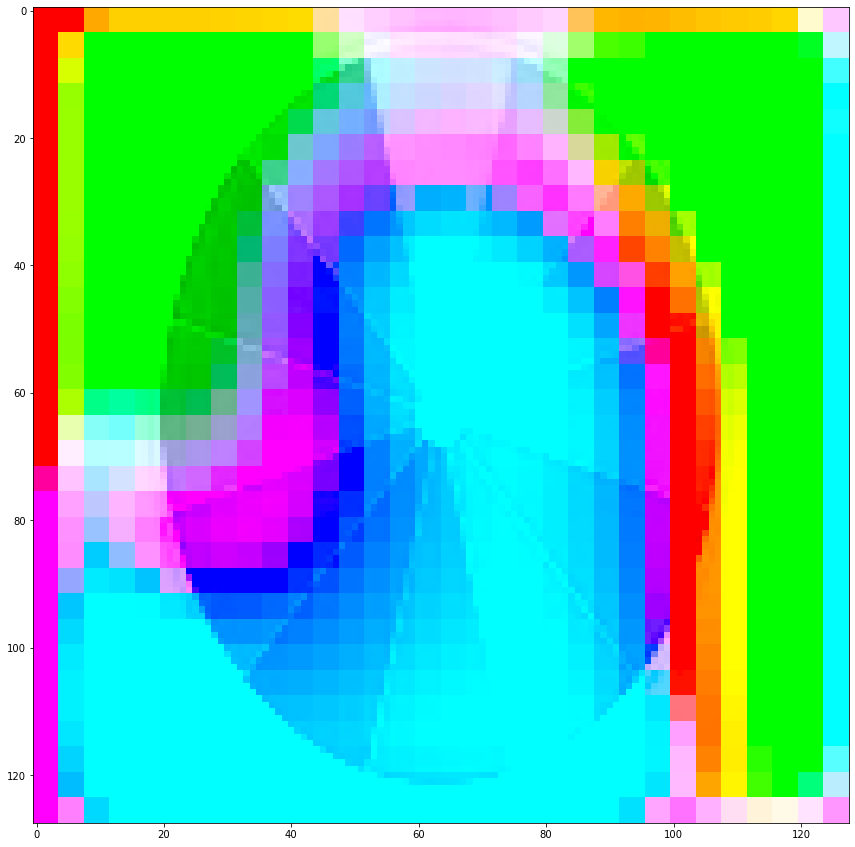

In [50]:
get_photo(image_pathway)